In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import numpy as np

#### setting working directory - REMOVE

In [ ]:
import os
os.chdir(os.getcwd())
os.chdir("C:/Users/MelodyPogula/Downloads")

## Read in Data

### Transaction

In [36]:
transaction = pd.read_csv("train_transaction.csv")
transaction_data = transaction.copy()


### Identity

In [ ]:
identity = pd.read_csv("train_identity.csv")
identity_data = identity.copy()


## Data for Random Forest 

In [15]:
identity_rf = identity_data.copy()
transaction_rf = transaction_data.copy()

### Function to inspect and analyze dataset

In [34]:
import pandas as pd
import numpy as np

def analyze_unknown_columns(df):
    """
    column analysis function translated from R
    """
    analysis_data = []
    
    for col in df.columns:
        col_data = df[col]
        
        # Basic info
        col_type = col_data.dtype
        na_percent = round(col_data.isna().mean() * 100, 2)
        unique_values = col_data.nunique()
        
        # Min/Max for numeric columns
        if np.issubdtype(col_type, np.number):
            if col_data.notna().any():
                min_val = round(col_data.min(), 2)
                max_val = round(col_data.max(), 2)
            else:
                min_val = "All NA"
                max_val = "All NA"
        else:
            min_val = "N/A"
            max_val = "N/A"
        
        # Sample values (first 5 non-null unique values)
        sample_vals = col_data.dropna().unique()[:5]
        sample_str = ", ".join(str(x) for x in sample_vals)
        
        analysis_data.append({
            'column': col,
            'type': col_type,
            'na_percent': na_percent,
            'unique_values': unique_values,
            'min_value': min_val,
            'max_value': max_val,
            'sample_values': sample_str
        })
    
    # Create analysis DataFrame
    column_analysis = pd.DataFrame(analysis_data)
    
    print("=== AUTOMATED COLUMN ANALYSIS ===")
    pd.set_option('display.max_rows', None)
    print(column_analysis)
    pd.reset_option('display.max_rows')
    
    return column_analysis



In [ ]:
#check memory usage

memory_mb = transaction_data.memory_usage(deep=True).sum() / 1024**2
print(f"Total memory: {memory_mb:.2f} MB")

Total memory: 1771.84 MB


In [33]:
#  analyze Usage
#column_info = analyze_unknown_columns(transaction_data)

### Handle Missing Data, impute for numeric columns

In [32]:
def handle_missing_columns(df, missing_threshold=0.2, drop_threshold=0.9, exclude_cols=None):
    """
    Optimized version that avoids fragmentation by collecting all indicators first.

    
    Create missingness indicators for columns with NA fraction >= missing_threshold.
    Drop original columns if NA fraction >= drop_threshold.
    Impute mean for numeric columns that are kept.
    encode categorical columns

    Parameters:
        df: DataFrame
        missing_threshold: create indicators for columns with NA >= this fraction
        drop_threshold: drop original columns if NA >= this fraction
        exclude_cols: list of columns not to modify (e.g., target, ID)

    Returns:
        df_copy: cleaned DataFrame
        dropped_cols: list of original columns that were dropped
    """

    df = df.copy()  # protect original

    if exclude_cols is None:
        exclude_cols = []

    cols = [c for c in df.columns if c not in exclude_cols]
    dropped_cols = []
    
    # Step 1: Create missing indicators for ALL columns above missing_threshold
    cols_for_indicators = []
    for col in cols:
        na_frac = df[col].isna().mean()
        if na_frac >= missing_threshold:
            cols_for_indicators.append(col)
    
    # Create all indicators at once
    if cols_for_indicators:
        missing_indicators = {}
        for col in cols_for_indicators:
            missing_indicators[f"{col}_missing"] = df[col].isna().astype(np.int8)
        
        indicators_df = pd.DataFrame(missing_indicators, index=df.index)
        df = pd.concat([df, indicators_df], axis=1)

    # Step 2: Now drop columns above drop_threshold
    cols_to_drop = []
    for col in cols:
        na_frac = df[col].isna().mean()
        if na_frac >= drop_threshold:
            cols_to_drop.append(col)
    
    df.drop(columns=cols_to_drop, inplace=True)
    dropped_cols = cols_to_drop.copy()
        
    
    # Step 3: Impute numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    numeric_cols = [c for c in numeric_cols if not c.endswith("_missing")]
    
    for col in numeric_cols:
        if df[col].isna().any():
            df[col] = df[col].fillna(df[col].mean())

    # Step 4: Handle categorical columns using tree-friendly preprocessing
    cat_cols = df.select_dtypes(include=['object']).columns
    
    # Binary columns (2 unique values, excluding NaN)
    binary_cols = [c for c in cat_cols if df[c].nunique(dropna=True) == 2]
    # Small multi-category columns (3–10 unique values)
    small_cat_cols = [c for c in cat_cols if 3 <= df[c].nunique(dropna=True) <= 10]
    # High-cardinality columns (>10 unique values)
    high_card_cols = [c for c in cat_cols if df[c].nunique(dropna=True) > 10]

    # --- Binary columns ---
    for col in binary_cols:
        vals = df[col].dropna().unique()
        mapping = {vals[0]: 0, vals[1]: 1}
        # Simply map and fill missing with -1
        df[col] = df[col].map(mapping).fillna(-1)

    # --- Small multi-category columns ---
    if small_cat_cols:
        df = pd.get_dummies(df, columns=small_cat_cols, dummy_na=True, drop_first=False)

    # --- High-cardinality columns ---
    for col in high_card_cols:
        freq = df[col].value_counts(dropna=False)
        df[col + "_freq"] = df[col].map(freq)
        df.drop(columns=[col], inplace=True)
    
    return df, dropped_cols

In [24]:
exclude = ["TransactionID", "isFraud"]

train_transaction_clean, dropped_cols = handle_missing_columns(
    transaction_rf, missing_threshold=0.2, drop_threshold=0.9, exclude_cols=exclude
)

print("Dropped columns:", dropped_cols)

Dropped columns: ['dist2']


In [28]:
#  analyze Usage
#column_info = analyze_unknown_columns(train_transaction_clean)

In [ ]:
#check memory usage

memory_mb = transaction_data.memory_usage(deep=True).sum() / 1024**2
print(f"Total memory: {memory_mb:.2f} MB")

Total memory: 1771.84 MB


In [29]:
exclude = ["TransactionID", "isFraud"]

train_identity_clean, dropped_cols = handle_missing_columns(
    identity_rf, missing_threshold=0.2, drop_threshold=0.9, exclude_cols=exclude
)

In [31]:
#  analyze Usage
#column_info = analyze_unknown_columns(train_identity_clean)

### Encoding

In [35]:
cat_cols = train_transaction_clean.select_dtypes(include=["object"]).columns
num_cols = train_transaction_clean.select_dtypes(exclude=["object"]).columns
# one-hot encode
rf_transaction_df = pd.get_dummies(train_transaction_clean, columns=cat_cols, drop_first=True)

In [ ]:
cat_cols = train_identity_clean.select_dtypes(include=["object"]).columns
num_cols = train_identity_clean.select_dtypes(exclude=["object"]).columns
# one-hot encode
rf_identity_df = pd.get_dummies(train_identity_clean, columns=cat_cols, drop_first=True)

In [ ]:
rf_transaction_df
rf_identity_df

TransactionID  id_01     id_02     id_03     id_04      id_05  \
0             2987004    0.0   70787.0  0.060189 -0.058938   1.615585   
1             2987008   -5.0   98945.0  0.060189 -0.058938   0.000000   
2             2987010   -5.0  191631.0  0.000000  0.000000   0.000000   
3             2987011   -5.0  221832.0  0.060189 -0.058938   0.000000   
4             2987016    0.0    7460.0  0.000000  0.000000   1.000000   
...               ...    ...       ...       ...       ...        ...   
144228        3577521  -15.0  145955.0  0.000000  0.000000   0.000000   
144229        3577526   -5.0  172059.0  0.060189 -0.058938   1.000000   
144230        3577529  -20.0  632381.0  0.060189 -0.058938  -1.000000   
144231        3577531   -5.0   55528.0  0.000000  0.000000   0.000000   
144232        3577534  -45.0  339406.0  0.060189 -0.058938 -10.000000   

            id_06     id_09     id_10  id_11  ...  DeviceInfo_verykoolS5019  \
0        -6.69871  0.091023 -0.301124  100.0  ...                     False   
1        -5.00000  0.091023 -0.301124  100.0  ...                     False   
2         0.00000  0.000000  0.000000  100.0  ...                     False   
3        -6.00000  0.091023 -0.301124  100.0  ...                     False   
4         0.00000  0.000000  0.000000  100.0  ...                     False   
...           ...       ...       ...    ...  ...                       ...   
144228    0.00000  0.000000  0.000000  100.0  ...                     False   
144229   -5.00000  0.091023 -0.301124  100.0  ...                     False   
144230  -36.00000  0.091023 -0.301124  100.0  ...                     False   
144231   -7.00000  0.000000  0.000000  100.0  ...                     False   
144232 -100.00000  0.091023 -0.301124  100.0  ...                     False   

        DeviceInfo_verykoolS5524  DeviceInfo_verykoolS5525  \
0                          False                     False   
1                          False                     False   
2                          False                     False   
3                          False                     False   
4                          False                     False   
...                          ...                       ...   
144228                     False                     False   
144229                     False                     False   
144230                     False                     False   
144231                     False                     False   
144232                     False                     False   

        DeviceInfo_verykoolS5530 Build/LMY47I  DeviceInfo_verykools4009  \
0                                       False                     False   
1                                       False                     False   
2                                       False                     False   
3                                       False                     False   
4                                       False                     False   
...                                       ...                       ...   
144228                                  False                     False   
144229                                  False                     False   
144230                                  False                     False   
144231                                  False                     False   
144232                                  False                     False   

        DeviceInfo_verykools5004  DeviceInfo_verykools5034  \
0                          False                     False   
1                          False                     False   
2                          False                     False   
3                          False                     False   
4                          False                     False   
...                          ...                       ...   
144228                     False                     False   
144229                     False        

## Data for XGBoost

In [ ]:
identity_xgb = identity_data.copy()
transaction_xgb = transaction_data.copy()

In [ ]:
cat_cols = transaction_xgb.select_dtypes(include=["object"]).columns
num_cols = transaction_xgb.select_dtypes(exclude=["object"]).columns
# one-hot encode
xgb_transaction_df = pd.get_dummies(transaction_xgb, columns=cat_cols, drop_first=True)

In [ ]:
cat_cols = identity_xgb.select_dtypes(include=["object"]).columns
num_cols = identity_xgb.select_dtypes(exclude=["object"]).columns
# one-hot encode
xgb_identity_df = pd.get_dummies(identity_xgb, columns=cat_cols, drop_first=True)

In [ ]:
xgb_transaction_df
xgb_identity_df

TransactionID  id_01     id_02  id_03  id_04  id_05  id_06  id_07  \
0             2987004    0.0   70787.0    NaN    NaN    NaN    NaN    NaN   
1             2987008   -5.0   98945.0    NaN    NaN    0.0   -5.0    NaN   
2             2987010   -5.0  191631.0    0.0    0.0    0.0    0.0    NaN   
3             2987011   -5.0  221832.0    NaN    NaN    0.0   -6.0    NaN   
4             2987016    0.0    7460.0    0.0    0.0    1.0    0.0    NaN   
...               ...    ...       ...    ...    ...    ...    ...    ...   
144228        3577521  -15.0  145955.0    0.0    0.0    0.0    0.0    NaN   
144229        3577526   -5.0  172059.0    NaN    NaN    1.0   -5.0    NaN   
144230        3577529  -20.0  632381.0    NaN    NaN   -1.0  -36.0    NaN   
144231        3577531   -5.0   55528.0    0.0    0.0    0.0   -7.0    NaN   
144232        3577534  -45.0  339406.0    NaN    NaN  -10.0 -100.0    NaN   

        id_08  id_09  ...  DeviceInfo_verykoolS5019  DeviceInfo_verykoolS5524  \
0         NaN    NaN  ...                     False                     False   
1         NaN    NaN  ...                     False                     False   
2         NaN    0.0  ...                     False                     False   
3         NaN    NaN  ...                     False                     False   
4         NaN    0.0  ...                     False                     False   
...       ...    ...  ...                       ...                       ...   
144228    NaN    0.0  ...                     False                     False   
144229    NaN    NaN  ...                     False                     False   
144230    NaN    NaN  ...                     False                     False   
144231    NaN    0.0  ...                     False                     False   
144232    NaN    NaN  ...                     False                     False   

        DeviceInfo_verykoolS5525  DeviceInfo_verykoolS5530 Build/LMY47I  \
0                          False                                  False   
1                          False                                  False   
2                          False                                  False   
3                          False                                  False   
4                          False                                  False   
...                          ...                                    ...   
144228                     False                                  False   
144229                     False                                  False   
144230                     False                                  False   
144231                     False                                  False   
144232                     False                                  False   

        DeviceInfo_verykools4009  DeviceInfo_verykools5004  \
0                          False                     False   
1                          False                     False   
2                          False                     False   
3                          False                     False   
4                          False                     False   
...                          ...                       ...   
144228                     False                     False   
144229                     False                     False   
144230                     False                     False   
144231                     False                     False   
144232                     False                     False   

        DeviceInfo_verykools5034  DeviceInfo_verykools5035  DeviceInfo_vivo  \
0                          False                     False            False   
1                          False                     False            False   
2                          False                     False            False   
3                          False                     False            False   
4                          False                     False           

## Data for CatBoost and Light GBM

In [ ]:
identity_boost = identity_data.copy()
transaction_boost = transaction_data.copy()

## List of Matching TransactionIDs

In [ ]:
identity = pd.read_csv("identity.csv")
merged_df = pd.merge(identity, transaction, on='TransactionID', how='inner')

overlapping_ids = merged_df['TransactionID'].tolist()

## EDA

### Class Imbalance

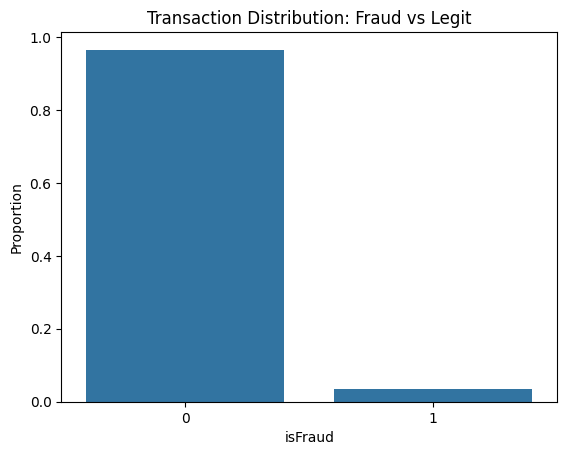

In [ ]:
### EDA
# fraud vs legit
fraud_counts = transaction['isFraud'].value_counts(normalize=True)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Transaction Distribution: Fraud vs Legit")
plt.xlabel("isFraud")
plt.ylabel("Proportion")
plt.show()

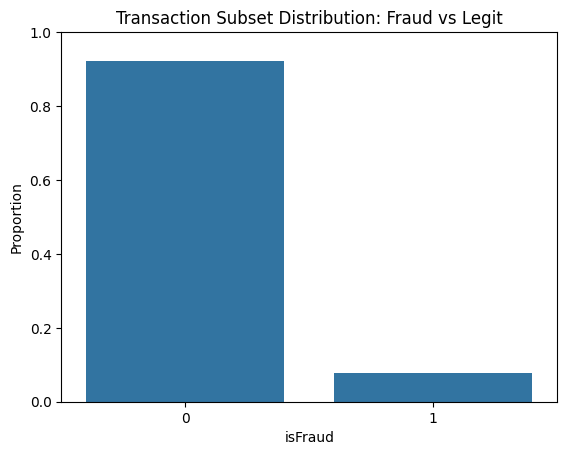

In [ ]:
fraud_counts = merged_df['isFraud'].value_counts(normalize=True)
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title("Transaction Subset Distribution: Fraud vs Legit")
plt.xlabel("isFraud")
plt.ylabel("Proportion")
plt.ylim(0,1)
plt.show()

### Column Analysis

In [ ]:
def analyze_unknown_columns(df):
    """
    column analysis function translated from R
    """
    analysis_data = []
    
    for col in df.columns:
        col_data = df[col]
        
        # Basic info
        col_type = col_data.dtype
        na_percent = round(col_data.isna().mean() * 100, 2)
        unique_values = col_data.nunique()
        
        # Min/Max for numeric columns
        if np.issubdtype(col_type, np.number):
            if col_data.notna().any():
                min_val = round(col_data.min(), 2)
                max_val = round(col_data.max(), 2)
            else:
                min_val = "All NA"
                max_val = "All NA"
        else:
            min_val = "N/A"
            max_val = "N/A"
        
        # Sample values (first 5 non-null unique values)
        sample_vals = col_data.dropna().unique()[:5]
        sample_str = ", ".join(str(x) for x in sample_vals)
        
        analysis_data.append({
            'column': col,
            'type': col_type,
            'na_percent': na_percent,
            'unique_values': unique_values,
            'min_value': min_val,
            'max_value': max_val,
            'sample_values': sample_str
        })
    
    # Create analysis DataFrame
    column_analysis = pd.DataFrame(analysis_data)
    
    print("=== AUTOMATED COLUMN ANALYSIS ===")
    pd.set_option('display.max_rows', None)
    print(column_analysis)
    pd.reset_option('display.max_rows')
    
    return column_analysis

#### Transaction

In [ ]:
column_info = analyze_unknown_columns(transaction)

=== AUTOMATED COLUMN ANALYSIS ===
             column     type  na_percent  unique_values min_value  max_value  \
0     TransactionID    int64        0.00         590540   2987000    3577539   
1           isFraud    int64        0.00              2         0          1   
2     TransactionDT    int64        0.00         573349     86400   15811131   
3    TransactionAmt  float64        0.00          20902      0.25   31937.39   
4         ProductCD   object        0.00              5       N/A        N/A   
5             card1    int64        0.00          13553      1000      18396   
6             card2  float64        1.51            500     100.0      600.0   
7             card3  float64        0.27            114     100.0      231.0   
8             card4   object        0.27              4       N/A        N/A   
9             card5  float64        0.72            119     100.0      237.0   
10            card6   object        0.27              4       N/A        N/A   
11    

#### Identity

In [ ]:
column_info = analyze_unknown_columns(identity)

=== AUTOMATED COLUMN ANALYSIS ===
           column     type  na_percent  unique_values min_value max_value  \
0   TransactionID    int64        0.00         144233   2987004   3577534   
1           id_01  float64        0.00             77    -100.0       0.0   
2           id_02  float64        2.33         115655       1.0  999595.0   
3           id_03  float64       54.02             24     -13.0      10.0   
4           id_04  float64       54.02             15     -28.0       0.0   
5           id_05  float64        5.11             93     -72.0      52.0   
6           id_06  float64        5.11            101    -100.0       0.0   
7           id_07  float64       96.43             84     -46.0      61.0   
8           id_08  float64       96.43             94    -100.0       0.0   
9           id_09  float64       48.05             46     -36.0      25.0   
10          id_10  float64       48.05             62    -100.0       0.0   
11          id_11  float64        2.26    